<a href="https://colab.research.google.com/github/egenya/DataAnalyst_learn/blob/main/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%80%D1%8E%D0%BA%D0%B7%D0%B0%D0%BA%D0%B0_ipynb%22%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![рюкзак.jpeg](https://cc98ea11-9cf2-4cd4-b74d-bbd51bc86f3d.selcdn.net/images/d_large/180097500.jpg)

Данные с конкурса [ backpack ] ('https://www.kaggle.com/competitions/playground-series-s5e2/overview')

 - Brand = Jansport, Under Armour, Nike, Adidas, Puma
 - Material = Leather, Canvas, Nylon, Polyester
 - Size = Medium, Small, Large
 - Compartments = Medium, Small, Large
 - Laptop_compartment = Yes, No
 -  Waterproof = Yes, No
 - Style = Tote, Messenger, Backpack
 - Color = Black, Green, Red, Blue, Gray, Pink
 - Weight Capacity (kg)
 - Price

# <font color='#11a642' size='6'> **Импорт и установка библиотек**

In [4]:
from google.colab import drive
import json
import zipfile

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split
!pip3 install category_encoders
import category_encoders as ce
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import make_pipeline


from sklearn.metrics import mean_absolute_error, mean_squared_error,f1_score, r2_score, median_absolute_error, explained_variance_score, max_error, root_mean_squared_error
from sklearn.metrics import (precision_score, recall_score,
                             roc_auc_score, roc_curve, f1_score)

from sklearn.model_selection import (cross_val_score, GridSearchCV,
                                     RandomizedSearchCV, train_test_split)

from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 103.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 5.3 MB/s eta 0:00:00


# <font color='#11a642' size='6'> **Загрузка данных**

In [6]:
def load_dataset(from_kaggle:bool = False) -> pd.DataFrame:
  '''
  Функция скачивает данные с сайта kaggle, если установлен from_kaggle=True,
  инчае архив считывается по ссылке с гугл диска (такой способ удобен тем, у кого нет доступа к kaggle)
  params:
      - from_kaggle - индикатор откуда скачивать данные (True - c сайта kaggle, False -  c google диска)
  return:
      - pd.DataFrame

  '''
  if from_kaggle:
    # запросит разрешение к гугл диску, необходимо дать это разрешение
    drive.mount('/content/drive')
    # установим kaggle
    !pip install kaggle -q
    !mkdir ~/.kaggle
    # копируем kaggle.json (предварительно, необходимо сгенерить токен на
    # сайте kaggle и сохранить к себе на гугл диск) в папку ~/.kaggle/
    !cp "/content/drive/MyDrive/Kaggle_API/kaggle.json" ~/.kaggle/
    !kaggle competitions download -c playground-series-s5e2
  else:
    !gdown 1-730JF1IWA5e_ejuXWLmkkzHFvudisdp
  # распаковка архива
  zip_ref = zipfile.ZipFile('playground-series-s5e2.zip', 'r')
  zip_ref.extractall()
  zip_ref.close()
  df_train = pd.read_csv('train.csv')
  df_test = pd.read_csv('test.csv')
  df_trainig_extra= pd.read_csv('training_extra.csv')
  df_sample_submission = pd.read_csv('sample_submission.csv')
  return df_train, df_test, df_sample_submission

In [7]:
df_train, df_test, df_sample_submission = load_dataset(from_kaggle=True)


Mounted at /content/drive
 87% 81.0M/92.7M [00:00<00:00, 211MB/s]
100% 92.7M/92.7M [00:00<00:00, 208MB/s]


In [8]:
# на этих данных дальше необходимо разработать модель
df_train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [9]:
pd.set_option('display.max_columns', 30)

In [10]:
df_train.columns= [col.lower().replace('?', ' ').rstrip().replace(' ', '_').replace('/', '_') for col in df_train]

## <font color='#11a642' size='5'> Определить роли для независимых признаков

In [11]:
#  Столбец с целевой переменной
id = 'id'
target = 'price' # столбец с целевой переменной

# <font color='#11a642' size='6'> **Разведочный анализ данных**

## <font color='#11a642' size='5'> Оценим размер датасета


1.   Сколько ГБ
2.   Сколько строк и столбцов



In [16]:
# Посмотрим сколько ГБ наш датасет
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   brand                 290295 non-null  object 
 2   material              291653 non-null  object 
 3   size                  293405 non-null  object 
 4   compartments          300000 non-null  float64
 5   laptop_compartment    292556 non-null  object 
 6   waterproof            292950 non-null  object 
 7   style                 292030 non-null  object 
 8   color                 290050 non-null  object 
 9   weight_capacity_(kg)  299862 non-null  float64
 10  price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


In [17]:
# Наш датасет занимает память 25 MB, состоит из 11 столбцов и 300000 строк
# Из них числовие 4 столбца и 7 категориальные

In [18]:
# Рассмотрим наши числовые столбцы
df_train.describe()

,id,compartments,weight_capacity_(kg),price
count,300000.000000,300000.000000,299862.000000,300000.000000
mean,149999.500000,5.443590,18.029994,81.411107
std,86602.684716,2.890766,6.966914,39.039340
min,0.000000,1.000000,5.000000,15.000000
25%,74999.750000,3.000000,12.097867,47.384620
50%,149999.500000,5.000000,18.068614,80.956120
75%,224999.250000,8.000000,24.002375,115.018160
max,299999.000000,10.000000,30.000000,150.000000


In [19]:
# Проверим на дубликаты
df_train.duplicated().sum()

0

In [20]:
# Разделим наши данные на категориальные и числовые для удобства.
features_cat = [col for col in df_train.select_dtypes(include='object').columns if col !=target]
features_int = [col for col in df_train.select_dtypes(exclude='object').columns if col !=target]

<Axes: ylabel='Frequency'>

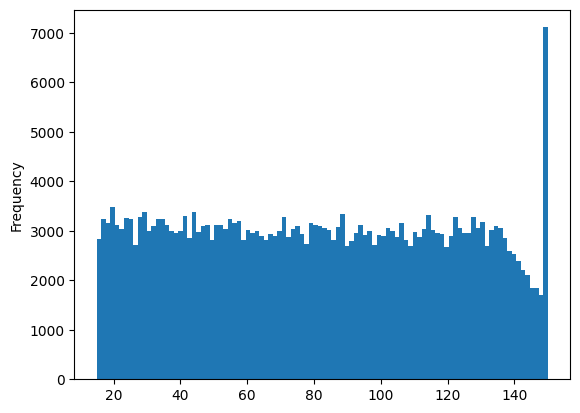

In [21]:
# Исследуем нашу целевую перменную на графике
df_train['price'].plot(kind= 'hist', bins = 100)

In [22]:
# Согласно графикам наш target содержит либо выбросы, либо действительно есть очень дорогие рюкзаки.

In [23]:
#  Рассмотрим наши данные на наличние выбросов на графике box
def get_charts(df_train, col):
  print(f'распределение для переменной {col}')
  print('____________________________________________________________________')

  f, ax = plt.subplots(1, 2, figsize=(10, 5))
  sns.boxplot(data=df_train, y=col, ax=ax[0])
  ax[0].set_title(f'{col} Distribution')

  sns.histplot(data=df_train, x='price', ax=ax[1])
  ax[1].set_title(f'{col} Distribution')
  plt.show()

распределение для переменной compartments
____________________________________________________________________


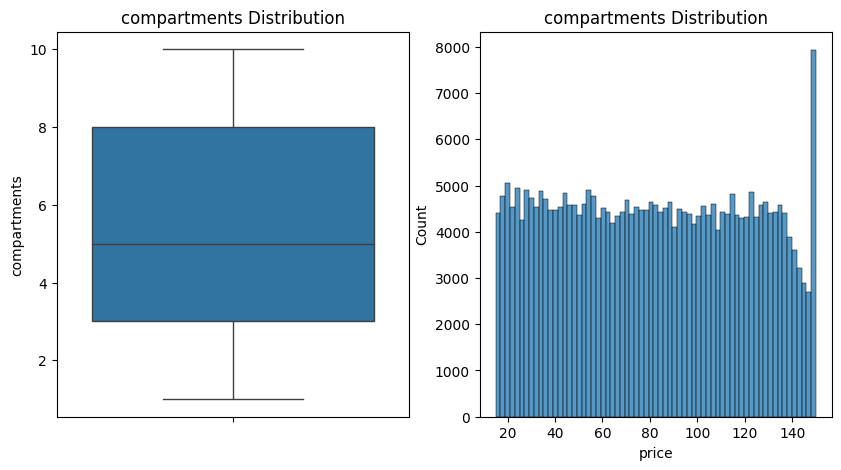

распределение для переменной weight_capacity_(kg)
____________________________________________________________________


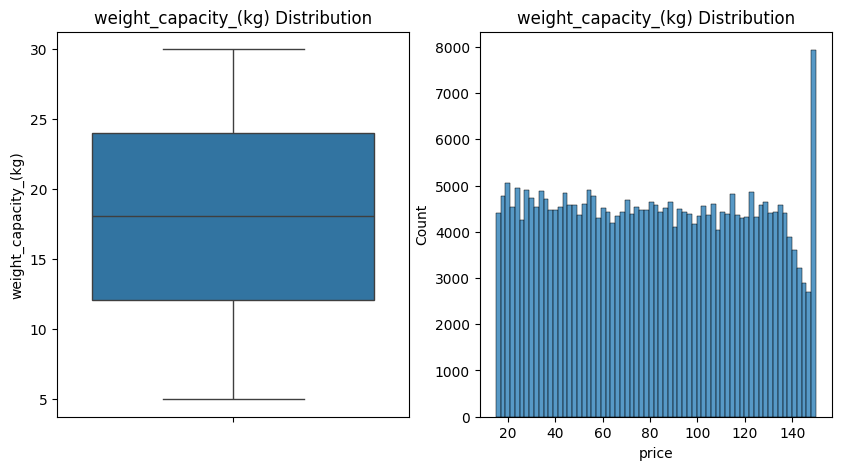

In [24]:
for col in df_train.select_dtypes(exclude='object').columns:
  if col not in  [id, target]:
    get_charts(df_train, col)

In [25]:
# В числовых и в катеогрилаьных данных выбросы отсутствуют

## <font color='#11a642' size='5'> Анализ пропусков


In [27]:
df_train.isna().sum()

,0
id,0
brand,9705
material,8347
size,6595
compartments,0
laptop_compartment,7444
waterproof,7050
style,7970
color,9950
weight_capacity_(kg),138


In [28]:
# Посмотрим процентное соотношение пропусков
for col in df_train.columns:
  print(f'{col}: {df_train[col].isna().sum() / df_train.shape[0] * 100:.2f}%')

id: 0.00%
brand: 3.23%
material: 2.78%
size: 2.20%
compartments: 0.00%
laptop_compartment: 2.48%
waterproof: 2.35%
style: 2.66%
color: 3.32%
weight_capacity_(kg): 0.05%
price: 0.00%


In [29]:
# В наших данных  8 столбцв содержать прощущенные значения (nan). Катерогиральных  7 и 1 числовой. Максимальное процентное соотношение столбец цвет.
# Произведем замену nan/

<Axes: >

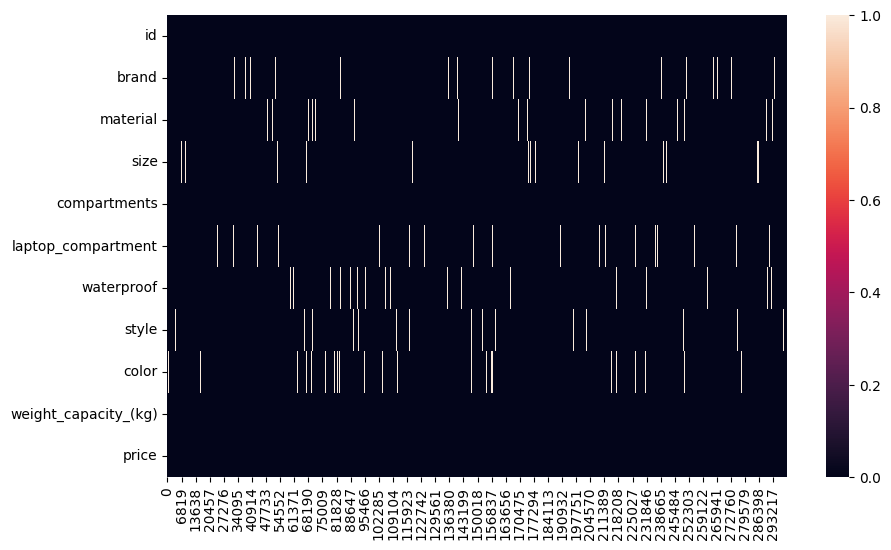

In [30]:
# Построим тепловую карту по нашим данным
plt.figure(figsize=(10,6))
sns.heatmap(df_train.isna().transpose())

Посмотрев тепловую карту и процентное содержание пропусков от общих данных делаем вывод. Рассмотреть каждую категорию подробно, и заменить пропущенные значания, т.к. исследуемая выборка не большая. И удаление можно повлечь неточность моделей данных.

In [31]:
# Удалим столбец id, так как он не несет информативности
del df_train['id']

In [32]:
# Рассмотрим числовой столбец weight_capacity_(kg)

<Axes: ylabel='Frequency'>

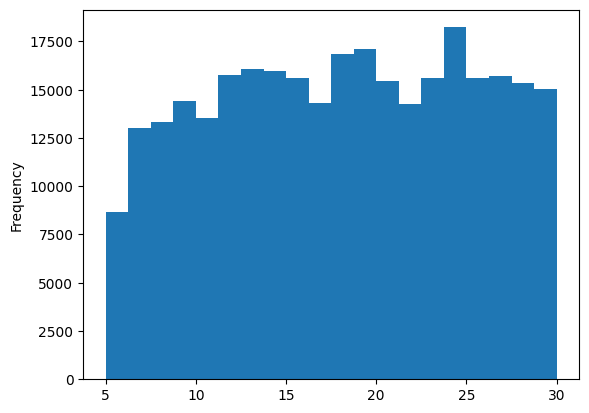

In [33]:
df_train['weight_capacity_(kg)'].plot(kind= 'hist', bins =20)

In [34]:
#  Числовой столбец с пропускаим у нас 1, заменим пропуски на среднее занчение
df_train['weight_capacity_(kg)'].fillna(df_train['weight_capacity_(kg)'].mean(), inplace=True)

<Axes: ylabel='Frequency'>

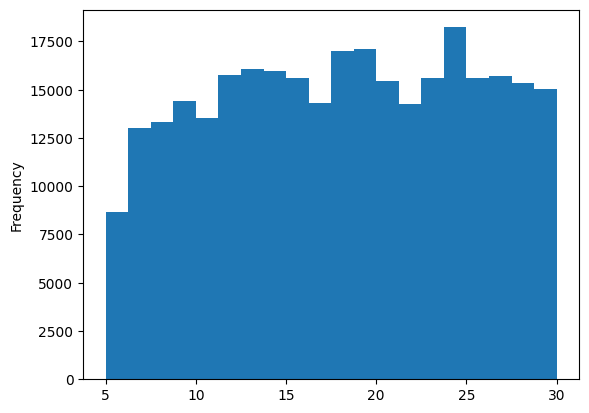

In [35]:
df_train['weight_capacity_(kg)'].plot(kind= 'hist', bins =20)
#  проверим на графике. распределение не изменилось

In [36]:
# Рассмотрим категориальные признаки

In [37]:
# Выгрузим информацию по категорильным столбцам
df_train[features_cat].describe()

,brand,material,size,laptop_compartment,waterproof,style,color
count,290295,291653,293405,292556,292950,292030,290050
unique,5,4,3,2,2,3,6
top,Adidas,Polyester,Medium,Yes,Yes,Messenger,Pink
freq,60077,79630,101906,148342,148077,100031,51690


In [38]:
df_train[df_train['brand'].isna()]

,brand,material,size,compartments,laptop_compartment,waterproof,style,color,weight_capacity_(kg),price
30,NaN,Leather,Large,3.0,No,Yes,Tote,Blue,21.304434,138.32699
48,NaN,Canvas,Medium,2.0,No,No,Tote,NaN,5.000000,42.28337
90,NaN,Leather,Medium,8.0,Yes,No,Tote,Blue,16.594824,142.11363
125,NaN,Polyester,Small,8.0,No,No,Backpack,Red,7.922756,64.32242
137,NaN,Nylon,Medium,3.0,Yes,No,Backpack,Green,13.051134,34.86676
...,...,...,...,...,...,...,...,...,...,...
299921,NaN,NaN,Small,7.0,No,Yes,Tote,NaN,20.419934,27.58667
299937,NaN,Polyester,Large,8.0,No,Yes,Messenger,Gray,19.272669,74.70298
299957,NaN,Polyester,Large,9.0,No,Yes,Tote,Black,13.619044,19.25284
299978,NaN,Canvas,Large,6.0,Yes,No,Tote,Gray,5.000000,50.78781


In [39]:
# пропущенные згачения в категориальных столбцах заменим на mody. Так как столбцы имеют не более 6 уникальных значений

In [40]:
df_train['brand'].unique()

array(['Jansport', 'Under Armour', 'Nike', 'Adidas', 'Puma', nan],
      dtype=object)

In [41]:
si = SimpleImputer(missing_values=np.nan, strategy = 'most_frequent')
si.fit(df_train[['brand', 'size', 'material', 'style', 'color', 'laptop_compartment', 'waterproof']])

SimpleImputer(strategy='most_frequent')

In [42]:
# Заполяем
transformed = si.transform(df_train[['brand', 'size', 'material', 'style', 'color', 'laptop_compartment', 'waterproof']])

In [43]:
# создадим массив и перезапишем в наш дата фрейм
df_train[['brand', 'size', 'material', 'style', 'color', 'laptop_compartment', 'waterproof']] = transformed

In [44]:
# Проверим пропуски

In [45]:
df_train.isna().sum()

,0
brand,0
material,0
size,0
compartments,0
laptop_compartment,0
waterproof,0
style,0
color,0
weight_capacity_(kg),0
price,0


In [46]:
# Все пропущенные значения заполнены

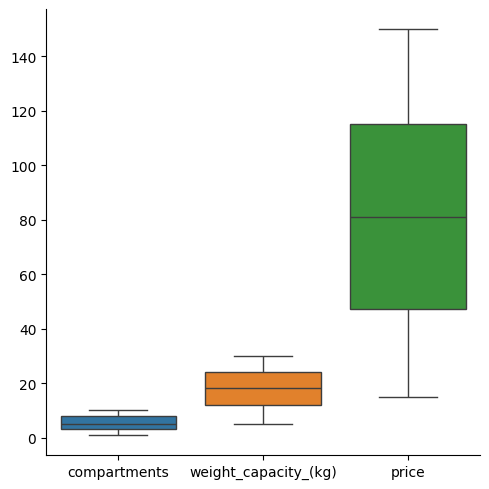

In [47]:
# Еще раз удебимся в отсутствуии выбросов,построим график
sns.catplot(df_train, kind= 'box')

In [48]:
# Убедились, что все столбцы готовы для посторения моделей

# <font color='#11a642' size='6'> **Подготовка данных к обучению**

Преобразуем все столбцы для дальнейшей работ

In [36]:
# Сохраним все изменения в новый дата  фрейм, чтобы избежать потери и искажения изначальных данных
df_train_1= pd.get_dummies(df_train, drop_first=True)

In [50]:
# Пеосле преобразования категориальных столбцов у нас сталов 25 столбцов bool и 14.0 МБ памяти

In [51]:
df_train_1.head()

,compartments,weight_capacity_(kg),price,brand_Jansport,brand_Nike,brand_Puma,brand_Under Armour,material_Leather,material_Nylon,material_Polyester,size_Medium,size_Small,laptop_compartment_Yes,waterproof_Yes,style_Messenger,style_Tote,color_Blue,color_Gray,color_Green,color_Pink,color_Red
0,7.0,11.611723,112.15875,True,False,False,False,True,False,False,True,False,True,False,False,True,False,False,False,False,False
1,10.0,27.078537,68.88056,True,False,False,False,False,False,False,False,True,True,True,True,False,False,False,True,False,False
2,2.0,16.643760,39.17320,False,False,False,True,True,False,False,False,True,True,False,True,False,False,False,False,False,True
3,8.0,12.937220,80.60793,False,True,False,False,False,True,False,False,True,True,False,True,False,False,False,True,False,False
4,1.0,17.749338,86.02312,False,False,False,False,False,False,False,True,False,True,True,True,False,False,False,True,False,False


# <font color='#11a642' size='6'> **Разделите данные на трейн и тест**

In [37]:
X = df_train_1.drop(['price'], axis = 1)
y = df_train_1[target]

In [38]:
#Преобразуем  наш у в дискретные данные
y = [int(label) for label in y]

In [39]:
# подготовка тестового и тренировочного наборов данных

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state= 42)

# <font color='#11a642' size='6'> **Построение Логистической регрессии**

In [55]:
# Преобразуем числовые признаки на обучающей выборке
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [56]:
# Построение модели логистической регрессии
logreg_model = LogisticRegression(solver='saga',  max_iter=100)
logreg_model.fit(X_train_scaled, y_train)

LogisticRegression(solver='saga')

In [57]:
y_pred = logreg_model.predict(X_test_scaled)
y_probs = logreg_model.predict_proba(X_test_scaled)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))
r2_log = r2_score(y_test, y_pred)
Accuracy_log = accuracy_score(y_test, y_pred)

Accuracy: 0.018166666666666668
R2: -3.095788004520262


In [58]:
# Посмотрим метрики
rmse_log = root_mean_squared_error(y_test, y_pred)
print("RMSE_train: {}".format(rmse_log))

RMSE_train: 78.93640935729356


* Показатели не очень хорошие, процент правильных ответов модели всего 10%. Попробуем подобрать гиперпараметры

# <font color='#11a642' size='6'> **Метод  KNN**

In [59]:
# Построим модель KN соседей. Зададим число соседей например 20

In [60]:
k= 20

In [61]:
Knn= KNeighborsClassifier(n_neighbors= k)

In [62]:
# Обучим модель
Knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [63]:
# Составим прогноз
y_pred = Knn.predict(X_test_scaled)
y_probs = Knn.predict_proba(X_test_scaled)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))
r2_Knn = r2_score(y_test, y_pred)
Accuracy_Knn = accuracy_score(y_test, y_pred)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.007344444444444444
R2: -1.3347365673257223


In [64]:
# Посмотрим метрики
rmse_knn = root_mean_squared_error(y_test, y_pred)
print("RMSE_train: {}".format(rmse_knn))

RMSE_train: 59.597435906812855


* Значения RMSE стало уменьшаться в сравнении с Логистическойрегрессией, а мы стремимся к меньшиму числу. А вот accuracy стал практически иделаьным.  Значит наша модель ошибается на 26%.


In [65]:
import matplotlib.pyplot as plt

In [67]:
# Попробуем найти оптимальное число соседей и уменьшить число ошибок

In [68]:
# Искать будем в ручную возьмем число соседей 40

In [69]:
n_neighbors= 40
model_k= KNeighborsClassifier(n_neighbors = n_neighbors, weights= 'distance')

In [70]:
# Обучим модель
model_k.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=40, weights='distance')

In [71]:
# Составим прогноз
y_pred = model_k.predict(X_test_scaled)
y_probs = model_k.predict_proba(X_test_scaled)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))
r2_Knn_best = r2_score(y_test, y_pred)
Accuracy_Knn_best = accuracy_score(y_test, y_pred)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.007555555555555556
R2: -0.9418068236283856


In [72]:
# # Увеличив число соседей до 40, посмотрев ошибки модели 75 %  отличный резульат.
# И так же видим изменения в показателе r2 он стал лучше.
# Но всеже посмотрим другие модели. Так как модель kn соседей имеет свойство переобучаться

# <font color='#11a642' size='6'> **Построение модели дерево решений**

## <font color='#11a642' size='5'> Построение максимального дерева без ограничений на гиперпараметры


In [73]:
# Построим Дерево решений
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

### <font color='#11a642' size='4'> Оценка качества  максимального дерева без ограничений на гиперпараметры


In [74]:
y_pred = tree.predict(X_test)
y_probs = tree.predict_proba(X_test_scaled)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))
r2_tree = r2_score(y_test, y_pred)
Accuracy_tree = accuracy_score(y_test, y_pred)

Accuracy: 0.007822222222222222
R2: -0.9930189101774405


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


### <font color='#11a642' size='4'> Выводы


 При построении дерева решений показатели Accuracy даже стал меньше. Попробуем рассмотреть подобрать наилучшие параметры для улучшения модели

## <font color='#11a642' size='5'> Построение дерева с поиском наилучших гиперапарметров


In [75]:
# Переберем занчения параметров.min_samples_leaf мин. кол-во листов, min_samples_split  мин. кол-во ветвей, max_depth глубина дерева
params_set ={'max_depth': [3, 4],
            'min_samples_leaf': [2, 6, 9],
            'min_samples_split': [4, 6, 12]}

In [76]:
#  используем GridSearchCV
grid_CV = GridSearchCV(tree, param_grid= params_set, cv= 5, scoring='accuracy', n_jobs= -1)

In [77]:
# Обучим нашу модель
grid_CV.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4], 'min_samples_leaf': [2, 6, 9],
                         'min_samples_split': [4, 6, 12]},
             scoring='accuracy')

# <font color='#11a642' size='6'> **Построение RandomForestClassifier**

In [34]:
#  Добавим бибилиотеки
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [40]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [42]:
y_pred = rf.predict(X_test)
y_probs = rf.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))
r2_rf= r2_score(y_test, y_pred)
Accuracy_rf = accuracy_score(y_test, y_pred)

Accuracy: 0.0077777777777777776
R2: -1.0016337460429683


 ### <font color='#11a642' size='4'> Отбор признаков (Feature Selection) с помощью алгоритма случайного леса

In [81]:
# чтобы отобрать наиболее существенные признаки для решения рассматриваемой задачи классификации.

In [82]:
feature_names = X.columns

In [83]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, feature_names[idx], importances[idx]))

Feature importances:
 1. feature 'weight_capacity_(kg)' (0.5220)
 2. feature 'compartments' (0.1789)
 3. feature 'waterproof_Yes' (0.0279)
 4. feature 'laptop_compartment_Yes' (0.0258)
 5. feature 'style_Messenger' (0.0228)
 6. feature 'style_Tote' (0.0218)
 7. feature 'material_Nylon' (0.0178)
 8. feature 'size_Small' (0.0176)
 9. feature 'brand_Nike' (0.0169)
10. feature 'brand_Puma' (0.0163)
11. feature 'material_Polyester' (0.0162)
12. feature 'material_Leather' (0.0144)
13. feature 'size_Medium' (0.0135)
14. feature 'brand_Jansport' (0.0135)
15. feature 'brand_Under Armour' (0.0133)
16. feature 'color_Pink' (0.0131)
17. feature 'color_Gray' (0.0128)
18. feature 'color_Blue' (0.0123)
19. feature 'color_Green' (0.0121)
20. feature 'color_Red' (0.0112)


In [84]:
best_features = indices[:8]
best_features_names = feature_names[best_features]
print(best_features_names)

Index(['weight_capacity_(kg)', 'compartments', 'waterproof_Yes',
       'laptop_compartment_Yes', 'style_Messenger', 'style_Tote',
       'material_Nylon', 'size_Small'],
      dtype='object')


In [85]:
# Построим столбцовую диаграмму, графически представляющую значимость первых 20 признаков:

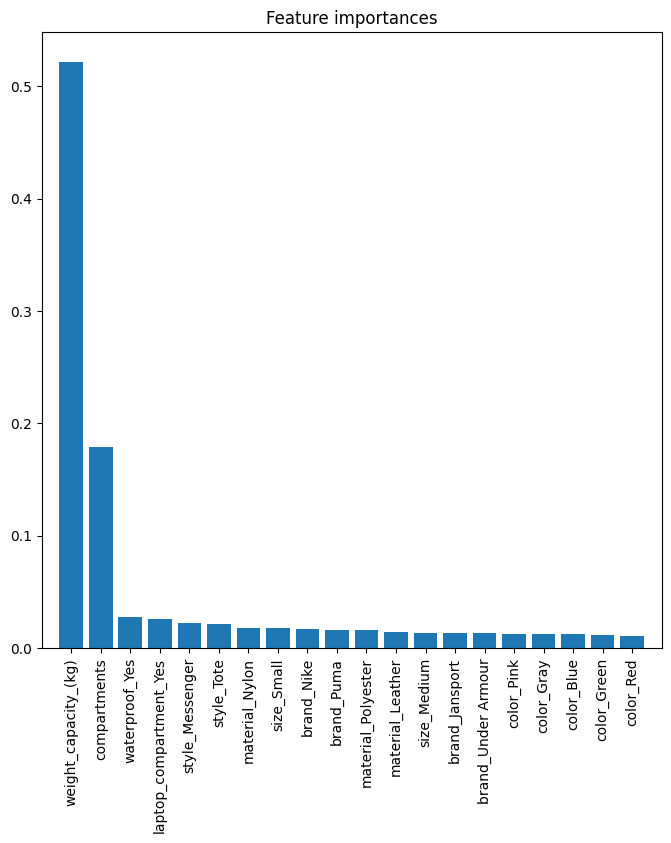

In [86]:
d_first = 20
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

In [87]:
# Как видно из диаграммы, основную роль играют признаки вес и наличие отсеков.Теперь можно попытаться использовать только эти признаки для обучения других моделей.

In [43]:
pd.DataFrame(data = [Accuracy_log, Accuracy_Knn, Accuracy_tree, Accuracy_rf],  columns=["% Ошибки"], index = ["LogisticRegression", "KNeighborsClassifier","DecisionTreeClassifier", "RandomForestClassifier"])

NameError: name 'Accuracy_log' is not defined

#<font color='#11a642' size='3'> Вывод: Рассмотрев 5 моделей, делаем вывод, что лучшие показатели у модели RandomForestClassifier

# <font color='#11a642' size='6'> **Предсказание тестовой выборки**

In [12]:
# это данные для примера, в таком виде необходимо сделать выборку и загрузить на kaggle
#  (для тех, кто хочет увидеть себя в лидерборде и оценить на сколько ваше решение лучше/хуже остальных data scientist)
df_sample_submission.head()

,id,Price
0,300000,81.411
1,300001,81.411
2,300002,81.411
3,300003,81.411
4,300004,81.411


In [13]:
# это тестовые данные, для которых необходимо предсказать target, то есть применить модель,
#  которую разработали на данных df_train
df_test.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


In [16]:
df_test.isna().sum()

,0
id,0
Brand,6227
Material,5613
Size,4381
Compartments,0
Laptop Compartment,4962
Waterproof,4811
Style,5153
Color,6785
Weight Capacity (kg),77


In [18]:
df_test.columns= [col.lower().replace('?', ' ').rstrip().replace(' ', '_').replace('/', '_') for col in df_test]

In [20]:
#  Числовой столбец с пропускаим у нас 1, заменим пропуски на среднее занчение
df_test['weight_capacity_(kg)'].fillna(df_test['weight_capacity_(kg)'].mean(), inplace=True)

<ipython-input-20-a66af147977e>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['weight_capacity_(kg)'].fillna(df_test['weight_capacity_(kg)'].mean(), inplace=True)


In [23]:
# Преобразуем категориальные столбцы. Сохраним все изменения в новый дата  фрейм, чтобы избежать потери и искажения изначальных данных
df_test_1= pd.get_dummies(df_test,drop_first=True)

In [25]:
df_test_1.isna().sum()

,0
id,0
compartments,0
weight_capacity_(kg),0
brand_Jansport,0
brand_Nike,0
brand_Puma,0
brand_Under Armour,0
material_Leather,0
material_Nylon,0
material_Polyester,0


In [30]:
X = df_test_1


In [45]:
predictions= rf.predict(X_train)

In [52]:
output= pd.DataFrame({'price': predictions})
output.to_csv('submission.csv', index =False)